<a href="https://colab.research.google.com/github/reolingovender/MIT805/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00


In [13]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [8]:
import datasets
from datasets import load_dataset
import numpy as np
import pandas as pd

In [9]:
datasets.logging.set_verbosity_error()
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

All_Beauty.jsonl:   0%|          | 0.00/327M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [16]:
df = pd.DataFrame(dataset['full'])

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [ ]:
df.head()

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Define sentiment analysis function using VADER
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']
    # if score['compound'] >= 0.05:
    #     return 'positive'
    # elif score['compound'] <= -0.05:
    #     return 'negative'
    # else:
    #     return 'neutral'

In [59]:
n = 200

In [60]:
df['text'][0:n].apply(get_sentiment)

,text
0,0.8162
1,0.7783
2,0.8070
3,0.0000
4,0.6369
...,...
195,0.3102
196,0.9123
197,0.7140
198,0.6082


In [61]:
df[['text', 'rating']][0:n]

,text,rating
0,This spray is really nice. It smells really go...,5.0
1,"This product does what I need it to do, I just...",4.0
2,"Smells good, feels great!",5.0
3,Felt synthetic,1.0
4,Love it,5.0
...,...,...
195,The flip top cap has a tab on it that has to b...,4.0
196,I love the tines on this long and short detang...,3.0
197,This comes in a one gallon jug. There are two ...,3.0
198,I used this on my three long-haired cats and i...,2.0


In [46]:
from transformers import pipeline
roberta_classifier = pipeline("sentiment-analysis" , model= "nlptown/bert-base-multilingual-uncased-sentiment")

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [47]:
def reboerta(text):
    score = roberta_classifier(text)[0].get('score')
    return score

In [62]:
df['text'][0:n].apply(reboerta)

,text
0,0.560469
1,0.565003
2,0.640327
3,0.374113
4,0.834829
...,...
195,0.403893
196,0.522273
197,0.504581
198,0.450351


In [63]:
x = df['rating'][0:n].to_list()
y = df['text'][0:n].apply(reboerta).to_list()

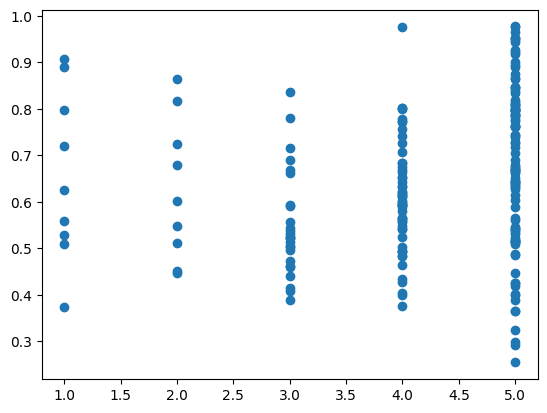

In [64]:
from matplotlib import pyplot as plt

plt.plot(x, y, 'o')

In [66]:
y1 = df['text'][0:n].apply(get_sentiment).to_list()

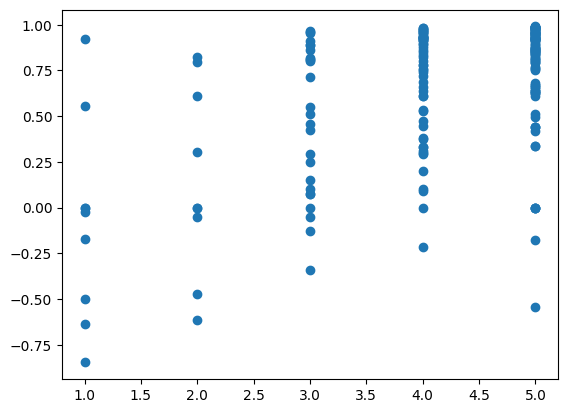

In [67]:
from matplotlib import pyplot as plt

plt.plot(x, y1, 'o')